In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import jax
import jax.numpy as jnp
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from idiots.dataset.dataloader import DataLoader
from idiots.experiments.grokking.training import restore, eval_step
from idiots.utils import metrics
import neural_tangents as nt
from einops import rearrange
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from functools import partial
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.ensemble import VotingClassifier

2024-02-20 16:20:39.943393: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-20 16:20:39.943498: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-20 16:20:39.984854: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-20 16:20:41.199775: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
checkpoint_dir = Path("../../logs/division/exp21/checkpoints")
batch_size = 512


def eval_checkpoint(step):
    config, state, ds_train, ds_test = restore(checkpoint_dir, step)

    def eval_loss_acc(ds):
        for batch in DataLoader(ds, batch_size):
            logs = eval_step(state, batch, config.loss_variant)
            metrics.log(**logs)
        [losses, accuracies] = metrics.collect("eval_loss", "eval_accuracy")
        loss = jnp.concatenate(losses).mean().item()
        acc = jnp.concatenate(accuracies).mean().item()
        return loss, acc

    train_loss, train_acc = eval_loss_acc(ds_train)
    test_loss, test_acc = eval_loss_acc(ds_test)

    return state, ds_train, ds_test, train_loss, train_acc, test_loss, test_acc

In [4]:
data = []
for step in range(0, 50000, 10000):
    state, ds_train, ds_test, train_loss, train_acc, test_loss, test_acc = eval_checkpoint(step)
    data.append(
        {
            "step": step,
            "state": state,
            "ds_train": ds_train, 
            "ds_test": ds_test,
            "train_loss": train_loss,
            "train_acc": train_acc,
            "test_loss": test_loss,
            "test_acc": test_acc,
        }
    )

2024-02-20 16:20:46.698164: W external/xla/xla/service/gpu/nvptx_compiler.cc:744] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


<Axes: xlabel='step', ylabel='accuracy'>

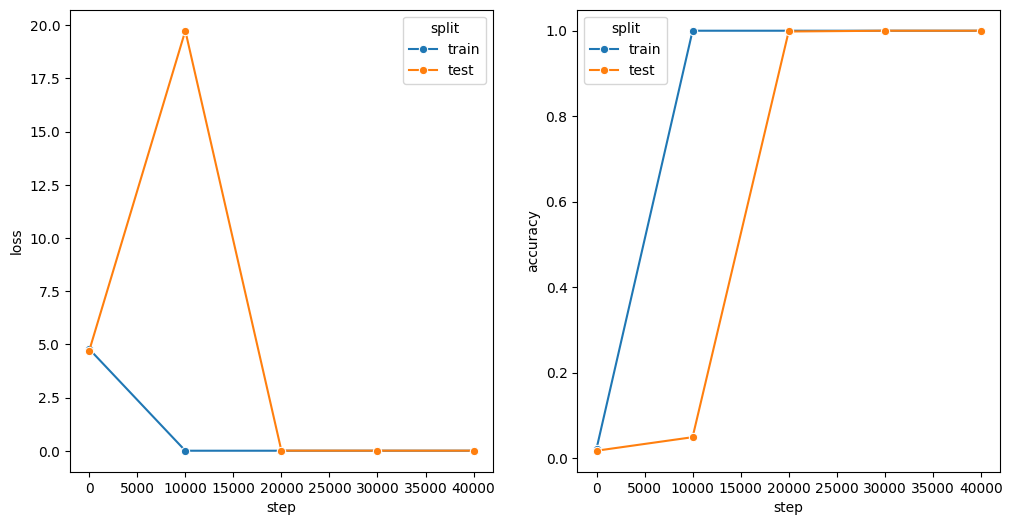

In [5]:
df = pd.DataFrame(data)

df_loss = df[["step", "train_loss", "test_loss"]]
df_loss = df_loss.melt("step", var_name="split", value_name="loss")
df_loss["split"] = df_loss["split"].str.replace("_loss", "")


df_acc = df[["step", "train_acc", "test_acc"]]
df_acc = df_acc.melt("step", var_name="split", value_name="accuracy")
df_acc["split"] = df_acc["split"].str.replace("_acc", "")

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

sns.lineplot(data=df_loss, x="step", y="loss", hue="split", marker="o", ax=axs[0])
sns.lineplot(data=df_acc, x="step", y="accuracy", hue="split", marker="o", ax=axs[1])

In [45]:
df = pd.DataFrame(data)
state_checkpoints = df['state'].tolist()
train_data_checkpoints = df['ds_train'].tolist()
test_data_checkpoints = df['ds_test'].tolist()

accuracy_checkpoints = [] 

N_train = 512
N_test = 512

print(test_data_checkpoints[0]['x'].shape)
assert(len(N * 2 < test_data_checkpoints[0]['x']))

X_train = jnp.array(train_data_checkpoints[0]['x'][:N_train])
Y_train = jnp.array(train_data_checkpoints[0]['y'][:N_train])

X_test = jnp.array(test_data_checkpoints[0]['x'][:N_test])
Y_test = jnp.array(test_data_checkpoints[0]['y'][:N_test])

for i in range(len(state_checkpoints)):

  print("checkpoint:", i)

  state = state_checkpoints[i]

  kernel_fn = nt.empirical_kernel_fn(state.apply_fn, 
        vmap_axes=0,
        implementation=nt.NtkImplementation.STRUCTURED_DERIVATIVES,)
  

  def get_kernel_layer(layer_num, args):
    X1, X2, kernel = args 

    X1_item = X1[layer_num]

    kernel_item = kernel_fn(jnp.array([X1_item]), jnp.array(X2), "ntk", state.params)
    kernel[layer_num] = kernel_item[0]

    return X1, X2, kernel
  

  def custom_kernel(X1, X2):
    # kernel = [[None for _ in range(len(X1))] for _ in range(len(X2))]
    # X1, X2, kernel = jax.lax.fori_loop(0, len(X1), get_kernel_layer, (X1, X2, kernel))

    kernel_fn_batched = nt.batch(kernel_fn, device_count=-1, batch_size=32)

    # print(kernel)

    return kernel_fn_batched(X1, X2, "ntk", state.params)

  svc = SVC(kernel=custom_kernel)
  
  svc.fit(X_train, Y_train)

  predictions = svc.predict(X_test)
  accuracy = accuracy_score(Y_test, predictions)

  accuracy_checkpoints.append(accuracy)

print(accuracy_checkpoints)


(1105, 4)
checkpoint: 0


/home/dylan/Documents/01_Computer_Science/III/Theory_of_Deep_Learning/idiots/venv/lib/python3.11/site-packages/neural_tangents/_src/empirical.py:2215: UserWarning: No Jacobian rule found for gather.
  warnings.warn(f'No Jacobian rule found for {primitive}.')
/home/dylan/Documents/01_Computer_Science/III/Theory_of_Deep_Learning/idiots/venv/lib/python3.11/site-packages/neural_tangents/_src/empirical.py:2215: UserWarning: No Jacobian rule found for gather.
  warnings.warn(f'No Jacobian rule found for {primitive}.')
